## Importing Libraries

In [ ]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 7.3 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234927 sha256=0d24b026e20bea3f1cd9487d65095032ba84a2de2ad1c94b1d85faa8d0c1b973
  Stored in directory: /root/.cache/pip/wheels/f3/e3/f2/1de1c2e3ed742e1df73e0f15d58864e50c7e64f607b548d6cf
Successfully built emoji


In [ ]:
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emoji
import string
import random
import time
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
import torch
from tqdm import tqdm
import spacy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch.optim as optim
from torch.autograd import Variable
from torchmetrics import F1Score
from torchmetrics.classification import BinaryF1Score

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
nlp = spacy.blank("en")
%matplotlib inline

In [ ]:
model_path = "drive/My Drive/ML4NLP_assignment/exercise_3/model/"

## Checking for GPU

In [ ]:
# use the GPU
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Loading Data From Github (One Time Only)

In [ ]:
# MOUNTING GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# LISTING DIRECTORIES IN /CONTENT/
!ls

drive  sample_data


In [ ]:
# NAVIGATING INTO DATA FOLDER
%cd drive/My Drive/ML4NLP_assignment/exercise_3/data

/content/drive/My Drive/ML4NLP_assignment/exercise_3/data


In [ ]:
# CLONING REPOSITORY INTO DATA FOLDER
! git clone https://github.com/cardiffnlp/tweeteval.git

Cloning into 'tweeteval'...
remote: Enumerating objects: 370, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 370 (delta 13), reused 1 (delta 1), pack-reused 354
Receiving objects: 100% (370/370), 8.49 MiB | 11.93 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [ ]:
# THE DATA IS CLONED INTO THE DATA FOLDER, CALLED TWEETEVAL
!ls

tweeteval


In [ ]:
# REMOVE UNNECESSARY DIRECTORIES AND FILES
!rm tweeteval/README.md
!rm tweeteval/TweetEval_Tutorial.ipynb
!rm -r tweeteval/.git
!rm tweeteval/evaluation_script.py
!rm -r tweeteval/predictions
!rm -r tweeteval/datasets/emoji/
!rm tweeteval/datasets/README.txt
!rm -r tweeteval/datasets/hate/
!rm -r tweeteval/datasets/irony/
!rm -r tweeteval/datasets/offensive/
!rm -r tweeteval/datasets/sentiment/
!rm -r tweeteval/datasets/stance/

In [ ]:
# GET LISTS OF FILES IN DIRECTORIES
def print_files_in_dir(path):
    dir_list = os.listdir(path)
    print("Files and directories in '", path, "' :")
    print(dir_list)
    return

print_files_in_dir("tweeteval/datasets/emotion")

Files and directories in ' tweeteval/datasets/emotion ' :
['mapping.txt', 'test_labels.txt', 'test_text.txt', 'train_labels.txt', 'train_text.txt', 'val_labels.txt', 'val_text.txt']


## Loading Data & Choosing Two Emotions (One Time Only)

In [ ]:
# MOUNTING GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/My Drive/ML4NLP_assignment/exercise_3/data/tweeteval/datasets/emotion/"
store_path = "/content/drive/My Drive/ML4NLP_assignment/exercise_3/data/my_data/"

# FUNCTION FOR LOADING DATA
def load_data(data_path, file_name, label=False):
    data_path = data_path + file_name
    df = pd.read_csv(data_path, on_bad_lines="skip", sep = "\n")
    df = pd.DataFrame(np.vstack([df.columns, df]))
    if label == True:
        df[0] = df[0].astype(int)
    return df

In [ ]:
# LOADING DATA
X_train = load_data(data_path, "train_text.txt")
y_train = load_data(data_path, "train_labels.txt", True)
X_val = load_data(data_path, "val_text.txt")
y_val = load_data(data_path, "val_labels.txt", True)
X_test = load_data(data_path, "test_text.txt")
y_test = load_data(data_path, "test_labels.txt", True)

In [ ]:
emotion_dict = {"anger": 0, "joy": 1, "optimism": 2, "sadness": 3}

In [ ]:
# CHOOSING TWO EMOTIONS
def filter_emotion(emotion_1, emotion_2, X_train, y_train, X_val, y_val, X_test, y_test):
    idx_1, idx_2 = (emotion_dict[emotion_1], emotion_dict[emotion_2])
    # TRAINING DATASET
    y_train = y_train[(y_train[0]==idx_1) | (y_train[0]==idx_2)]
    y_train_idx = list(y_train.index)
    X_train = X_train.iloc[y_train_idx]
    X_train.name = "X_train"
    y_train.name = "y_train"
    # VALIDATION DATASET
    y_val = y_val[(y_val[0]==idx_1) | (y_val[0]==idx_2)]
    y_val_idx = list(y_val.index)
    X_val = X_val.iloc[y_val_idx]
    X_val.name = "X_val"
    y_val.name = "y_val"
    # TESTING DATASET
    y_test = y_test[(y_test[0]==idx_1) | (y_test[0]==idx_2)]
    y_test_idx = list(y_test.index)
    X_test = X_test.iloc[y_test_idx]
    X_test.name = "X_test"
    y_test.name = "y_test"
    return X_train, y_train, X_val, y_val, X_test, y_test

#### Joy & Sadness

In [ ]:
# SAVE DATASET
X_train_13, y_train_13, X_val_13, y_val_13, X_test_13, y_test_13 = filter_emotion("joy", "sadness", 
                                                                                  X_train, y_train, 
                                                                                  X_val, y_val, 
                                                                                  X_test, y_test)

for df in [X_train_13, y_train_13, X_val_13, y_val_13, X_test_13, y_test_13]:
    df.to_hdf(store_path + "joy_sadness/" + df.name + ".h5", key="df")

#### Anger & Sadness

In [ ]:
# SAVE DATASET
X_train_03, y_train_03, X_val_03, y_val_03, X_test_03, y_test_03 = filter_emotion("anger", "sadness", 
                                                                                  X_train, y_train, 
                                                                                  X_val, y_val, 
                                                                                  X_test, y_test)

for df in [X_train_03, y_train_03, X_val_03, y_val_03, X_test_03, y_test_03]:
    df.to_hdf(store_path + "anger_sadness/" + df.name + ".h5", key="df")

## Classes & Functions

In [ ]:
# LOADING DATA
def load_data(data_path):
    X_train = pd.read_hdf(data_path + "X_train.h5", "df")  
    y_train = pd.read_hdf(data_path + "y_train.h5", "df")  
    X_val = pd.read_hdf(data_path + "X_val.h5", "df")  
    y_val = pd.read_hdf(data_path + "y_val.h5", "df")  
    X_test = pd.read_hdf(data_path + "X_test.h5", "df")  
    y_test = pd.read_hdf(data_path + "y_test.h5", "df") 
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
# STANDARD DATA PREPROCESSING STEPS
class DataPreprocessing():

    def __init__(self):
        return

    # LOWERCASING
    def convert_lowercase(self, text):
        text = text.str.lower()
        return text

    # REPLACING HTML TAGS AND URLS
    def remove_html_url(self, text):
        re_html = re.compile("<.*?>")
        re_url = re.compile("https?://\S+|www\.\S+")
        wo_html_str = re_html.sub(r"", text)
        wo_html_url_str = re_url.sub("", wo_html_str)
        return wo_html_url_str

    # REMOVING EMOJIS
    def remove_emoji(self, text):
        text = emoji.demojize(text)
        return text

    # REMOVING PUNCTUATIONS & NUMBERS
    def remove_punctuation_number(self, text):
        text = text.str.replace('[{}]'.format(string.punctuation), "", regex=True)
        text = text.str.replace("\d+", "", regex=True)
        return text

    # REMOVING SINGLE CHARACTER WORDS
    def remove_single_char_word(self, text):
        text = text.str.replace("[ \t\r\f\v]\w[ \t\r\f\v]", " ", regex=True)
        return text

    # APPLY ALL CLEANING STEPS
    def clean(self, X):
        res = self.convert_lowercase(X)
        res = res.apply(self.remove_html_url)
        res = res.apply(self.remove_emoji)
        res = self.remove_punctuation_number(res)
        res = self.remove_single_char_word(res)
        return res

In [ ]:
def tokenise(texts):

  max_len = 0
  tokenised_word = []
  word2idx = {}

  # ADD <pad> AND <unk> TOKENS TO THE VOCABULARY
  word2idx['<pad>'] = 0
  word2idx['<unk>'] = 1

  # INDEXING VOCABULARIES FROM INDEX 2
  idx = 2
  for sentence in texts:
    tokenised_sentence = nlp(sentence)
    # ADD EACH SENTENCE TO TOKENISED_SENTENCE
    tokenised_word.append(tokenised_sentence)
    # ADD NEW TOKEN TO WORD2IDX
    for token in tokenised_sentence:
      # ONLY WORDS THAT HAVEN'T APPEAR IN WORD2IDX BEFORE, AND LENGTH > 1
      if token.text not in word2idx:
        word2idx[token.text] = idx
        idx += 1

    # UPDATE MAX_LEN
    max_len = max(max_len, len(tokenised_sentence))

  return tokenised_word, word2idx, max_len

In [ ]:
def encode(tokenized_texts, word2idx, max_len, y):
    input_ids = []
    for tokenized_sent in tokenized_texts:
        # PAD SENTENCES TO MAX_LEN
        tokenized_padded_sent = list(tokenized_sent) + ['<pad>'] * (max_len - len(tokenized_sent))
 
        # ENCODE TOKENS
        input_id = [word2idx.get(str(token)) if word2idx.get(str(token)) != None \
                    else 1 for token in tokenized_padded_sent]
        input_ids.append(input_id)
    
    # CONVERT TO TORCH TENSOR
    X_input = torch.from_numpy(np.array(input_ids))
    y_label = torch.from_numpy(y[0].values)
    
    return X_input, y_label

In [ ]:
# DATALOADER DATA
def data_preparation(input, label, batch_size):
    data = TensorDataset(input, label)
    dataloader = DataLoader(data, batch_size=batch_size)
    return dataloader

In [ ]:
# CNN ARCHITECTURE 2
class CNN(nn.Module):
    def __init__(self, vocab_size, # len(word2idx)
                       embed_dim=100,
                       filter_sizes=[2, 4, 6],
                       stride=[1, 1, 1],
                       padding=[0, 0, 0],
                       dilation=[1, 1, 1],
                       num_filters=[100, 100, 100],
                       num_classes=2,
                       dropout=0.2):
        """
        The constructor for CNN class.
        Args:
            vocab_size (int):         Vocabulary size.
            embed_dim (int):          Dimension of word vectors.
                                      when pretrained word embeddings are not used. 
                                      Default: 300
            filter_sizes (List[int]): List of filter sizes (size of window). 
                                      Default: [2, 4, 6]
            num_filters (List[int]):  List of number of filters (number of output channel), 
                                      has the samelength as `filter_sizes`. 
                                      Default: [100, 100, 100]
            n_classes (int):          Number of classes. Default: 2
            dropout (float):          Dropout rate. Default: 0.5
        """

        super(CNN, self).__init__()
        # RANDOM EMBEDDING LAYER
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=self.embed_dim,
                                      padding_idx=0,
                                      max_norm=5.0)
        # CONVOLUTION LAYER
        self.conv1d_list = nn.ModuleList([nn.Conv1d(in_channels=self.embed_dim,
                                                    out_channels=num_filters[i],
                                                    kernel_size=filter_sizes[i],
                                                    stride=stride[i],
                                                    padding=padding[i],
                                                    dilation=dilation[i])
                                          for i in range(len(filter_sizes))])
        # FULLY CONNECTED LAYER AND DROPOUT
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        # self.fc = nn.LogSoftmax(dim=2)
        # self.fc = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_idx):
        """
        Perform a forward pass through the network.
        Args:
            input_idx (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)
        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # INPUT: input_idx;   SIZE: (batch_size, max_len)
        # OUTPUT: x_embed;    SIZE: (batch_size, max_len, embed_dim)
        x_embed = self.embedding(input_idx).float()

        # INPUT: x_embed;        SIZE: (batch_size, max_len, embed_dim)
        # OUTPUT: x_reshaped;    SIZE: (batch_size, embed_dim, max_len)
        # embed_dim IS THE CHANNEL SIZE
        x_reshaped = x_embed.permute(0, 2, 1)

        # INPUT: x_reshaped;                    SIZE: (batch_size, embed_dim,    max_len   )
        #                                             (__________, CHANNEL_SIZE, SIGNAL_LEN)
        # OUTPUT: conv1d(x_reshaped);           SIZE: (batch_size, num_filters[i]     , _)
        #                                             (__________, OUTPUT_CHANNEL_SIZE, _)
        # INPUT: conv1d(x_reshaped);            SIZE: (batch_size, num_filters[i], _)
        # OUTPUT: F.relu(conv1d(x_reshaped));   SIZE: (batch_size, num_filters[i], _)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # INPUT: x_conv;    SIZE: (batch_size, num_filters[i], _)
        # OUTPUT: x_pool;   SIZE: (batch_size, num_filters[i], 1)
        d = nn.Dropout(0.2)
        x_pool_list = [d(F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]))
                       for x_conv in x_conv_list]
        
        # CONCATENATE x_pool_list TO FEED THE FULLY CONNECTED LAYER
        # INPUT: x_pool_list;    SIZE: (batch_size, num_filters[i], 1) EACH
        # OUTPUT: x_fc;          SIZE: (batch_size, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # INPUT: x_fc;       SIZE: (batch_size, sum(num_filters))
        # OUTPUT: logits;    SIZE: (batch_size, 2 CLASSES)
        logits = self.fc(self.dropout(x_fc))

        # INPUT: logits;     SIZE: (batch_size, 2 CLASSES)
        # OUTPUT: logits;    SIZE: (batch_size, 2 CLASSES)
        m = nn.Sigmoid()
        logits = m(logits)

        return logits

In [ ]:
# CNN ARCHITECTURE 2
class CNN_1(nn.Module):
    def __init__(self, vocab_size, # len(word2idx)
                       embed_dim=100,
                       filter_sizes=[2, 4, 6],
                       stride=[1, 1, 1],
                       padding=[0, 0, 0],
                       dilation=[1, 1, 1],
                       num_filters=[100, 100, 100],
                       num_classes=2,
                       dropout=0.2):
        """
        The constructor for CNN class.
        Args:
            vocab_size (int):         Vocabulary size.
            embed_dim (int):          Dimension of word vectors.
                                      when pretrained word embeddings are not used. 
                                      Default: 300
            filter_sizes (List[int]): List of filter sizes (size of window). 
                                      Default: [2, 4, 6]
            num_filters (List[int]):  List of number of filters (number of output channel), 
                                      has the samelength as `filter_sizes`. 
                                      Default: [100, 100, 100]
            n_classes (int):          Number of classes. Default: 2
            dropout (float):          Dropout rate. Default: 0.5
        """

        super(CNN_1, self).__init__()
        # RANDOM EMBEDDING LAYER
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=self.embed_dim,
                                      padding_idx=0,
                                      max_norm=5.0)
        # CONVOLUTION LAYER
        self.conv1d_list = nn.ModuleList([nn.Conv1d(in_channels=self.embed_dim,
                                                    out_channels=num_filters[i],
                                                    kernel_size=filter_sizes[i],
                                                    stride=stride[i],
                                                    padding=padding[i],
                                                    dilation=dilation[i])
                                          for i in range(len(filter_sizes))])
        # FULLY CONNECTED LAYER AND DROPOUT
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        # self.fc = nn.LogSoftmax(dim=2)
        # self.fc = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_idx):
        """
        Perform a forward pass through the network.
        Args:
            input_idx (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)
        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # INPUT: input_idx;   SIZE: (batch_size, max_len)
        # OUTPUT: x_embed;    SIZE: (batch_size, max_len, embed_dim)
        x_embed = self.embedding(input_idx).float()

        # INPUT: x_embed;        SIZE: (batch_size, max_len, embed_dim)
        # OUTPUT: x_reshaped;    SIZE: (batch_size, embed_dim, max_len)
        # embed_dim IS THE CHANNEL SIZE
        x_reshaped = x_embed.permute(0, 2, 1)

        # INPUT: x_reshaped;                    SIZE: (batch_size, embed_dim,    max_len   )
        #                                             (__________, CHANNEL_SIZE, SIGNAL_LEN)
        # OUTPUT: conv1d(x_reshaped);           SIZE: (batch_size, num_filters[i]     , _)
        #                                             (__________, OUTPUT_CHANNEL_SIZE, _)
        # INPUT: conv1d(x_reshaped);            SIZE: (batch_size, num_filters[i], _)
        # OUTPUT: F.relu(conv1d(x_reshaped));   SIZE: (batch_size, num_filters[i], _)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # INPUT: x_conv;    SIZE: (batch_size, num_filters[i], _)
        # OUTPUT: x_pool;   SIZE: (batch_size, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
                       for x_conv in x_conv_list]
        
        # CONCATENATE x_pool_list TO FEED THE FULLY CONNECTED LAYER
        # INPUT: x_pool_list;    SIZE: (batch_size, num_filters[i], 1) EACH
        # OUTPUT: x_fc;          SIZE: (batch_size, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # INPUT: x_fc;       SIZE: (batch_size, sum(num_filters))
        # OUTPUT: logits;    SIZE: (batch_size, 2 CLASSES)
        logits = self.fc(self.dropout(x_fc))

        # INPUT: logits;     SIZE: (batch_size, 2 CLASSES)
        # OUTPUT: logits;    SIZE: (batch_size, 2 CLASSES)
        m = nn.Sigmoid()
        logits = m(logits)

        return logits

In [ ]:
# CNN ARCHITECTURE 2
class CNN_2(nn.Module):
    def __init__(self, vocab_size, # len(word2idx)
                       embed_dim=100,
                       filter_sizes=[2, 4, 6],
                       stride=[1, 1, 1],
                       padding=[0, 0, 0],
                       dilation=[1, 1, 1],
                       num_filters=[100, 100, 100],
                       num_classes=2,
                       dropout=0.2):
        """
        The constructor for CNN class.
        Args:
            vocab_size (int):         Vocabulary size.
            embed_dim (int):          Dimension of word vectors.
                                      when pretrained word embeddings are not used. 
                                      Default: 300
            filter_sizes (List[int]): List of filter sizes (size of window). 
                                      Default: [2, 4, 6]
            num_filters (List[int]):  List of number of filters (number of output channel), 
                                      has the samelength as `filter_sizes`. 
                                      Default: [100, 100, 100]
            n_classes (int):          Number of classes. Default: 2
            dropout (float):          Dropout rate. Default: 0.5
        """

        super(CNN_2, self).__init__()
        # RANDOM EMBEDDING LAYER
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=self.embed_dim,
                                      padding_idx=0,
                                      max_norm=5.0)
        # CONVOLUTION LAYER
        self.conv1d_list = nn.ModuleList([nn.Conv1d(in_channels=self.embed_dim,
                                                    out_channels=num_filters[i],
                                                    kernel_size=filter_sizes[i],
                                                    stride=stride[i],
                                                    padding=padding[i],
                                                    dilation=dilation[i])
                                          for i in range(len(filter_sizes))])
        # FULLY CONNECTED LAYER AND DROPOUT
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        # self.fc = nn.LogSoftmax(dim=2)
        # self.fc = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_idx):
        """
        Perform a forward pass through the network.
        Args:
            input_idx (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)
        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # INPUT: input_idx;   SIZE: (batch_size, max_len)
        # OUTPUT: x_embed;    SIZE: (batch_size, max_len, embed_dim)
        x_embed = self.embedding(input_idx).float()

        # INPUT: x_embed;        SIZE: (batch_size, max_len, embed_dim)
        # OUTPUT: x_reshaped;    SIZE: (batch_size, embed_dim, max_len)
        # embed_dim IS THE CHANNEL SIZE
        x_reshaped = x_embed.permute(0, 2, 1)

        # INPUT: x_reshaped;                    SIZE: (batch_size, embed_dim,    max_len   )
        #                                             (__________, CHANNEL_SIZE, SIGNAL_LEN)
        # OUTPUT: conv1d(x_reshaped);           SIZE: (batch_size, num_filters[i]     , _)
        #                                             (__________, OUTPUT_CHANNEL_SIZE, _)
        # INPUT: conv1d(x_reshaped);            SIZE: (batch_size, num_filters[i], _)
        # OUTPUT: F.relu(conv1d(x_reshaped));   SIZE: (batch_size, num_filters[i], _)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # INPUT: x_conv;    SIZE: (batch_size, num_filters[i], _)
        # OUTPUT: x_pool;   SIZE: (batch_size, num_filters[i], 1)
        x_pool_list = [F.avg_pool1d(x_conv, kernel_size=x_conv.shape[2])
                       for x_conv in x_conv_list]
        
        # CONCATENATE x_pool_list TO FEED THE FULLY CONNECTED LAYER
        # INPUT: x_pool_list;    SIZE: (batch_size, num_filters[i], 1) EACH
        # OUTPUT: x_fc;          SIZE: (batch_size, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # INPUT: x_fc;       SIZE: (batch_size, sum(num_filters))
        # OUTPUT: logits;    SIZE: (batch_size, 2 CLASSES)
        logits = self.fc(self.dropout(x_fc))

        # INPUT: logits;     SIZE: (batch_size, 2 CLASSES)
        # OUTPUT: logits;    SIZE: (batch_size, 2 CLASSES)
        m = nn.Sigmoid()
        logits = m(logits)

        return logits

In [ ]:
# TRAINING
def train(y_train, y_val, train_dataloader, val_dataloader, epoch_num, loss_fn, model_name, emotion_pair):

    train_loss_epoch = []
    train_acc_epoch = []
    val_loss_epoch = []
    val_acc_epoch = []
    best_val_acc = 0

    # START TRAINING LOOP
    print("Start training...\n")
    print(f"{'Epoch':^10} | {'Train Loss':^12} | {'Val Loss':^12} | {'Train Accuracy (%)':^20} | {'Val Accuracy (%)':^20}")
    print("-"*89)

    for epoch_i in range(epoch_num):

        # RESET TOTAL_LOSS
        total_loss = 0
        total_loss_val = 0
        preds = []
        preds_val = []

        # for step, batch in enumerate(train_dataloader):
        for b_input_idx, b_labels in train_dataloader:

            # PUT MODEL INTO TRAINING MODE
            model.train()

            # LOAD BATCH TO DEVICE
            b_input_idx = b_input_idx.to(device)
            b_labels = b_labels.to(device)

            # RESET PREVIOUSLY CALCULATED GRADIENTS
            optimizer.zero_grad()

            # PERFORM A FORWARD PASS
            logits = model(b_input_idx).type(torch.float)

            # GET ACCURACY
            preds.extend(logits.argmax(axis=1).numpy())
            
            # COMPUTE LOSS
            # pred_class = logits.argmax(axis=1).type(torch.float)
            # pred_class = Variable(pred_class, requires_grad=True)
            # loss = loss_fn(input=pred_class, target=b_labels.type(torch.float))
            loss = loss_fn(logits, b_labels)

            # ACCUMULATE LOSS FOR EACH BATCH
            total_loss += loss.item()

            # PERFORM A BACKWARD PASS TO CALCULATE GRADIENTS
            loss.backward()

            # UPDATE PARAMETERS
            optimizer.step()

        # LOSS
        avg_train_loss = total_loss / len(y_train[0].values)
        train_loss_epoch.append(avg_train_loss)
        # ACCURACY
        y_train_tensor = torch.tensor(y_train[0].values)
        pred = torch.FloatTensor(np.array(preds))
        acc = torch.eq(pred, y_train_tensor).type(torch.int).sum().item()/len(y_train[0].values)*100
        train_acc_epoch.append(acc)


        for b_input_idx, b_labels in val_dataloader:

            # PUT MODEL INTO EVALUATION MODE
            model.eval()
            
            # LOAD BATCH TO DEVICE
            b_input_idx = b_input_idx.to(device)
            b_labels = b_labels.to(device)

            # PERFORM A FORWARD PASS
            with torch.no_grad():
                logits = model(b_input_idx).type(torch.float)

            # GET ACCURACY
            preds_val.extend(logits.argmax(axis=1).numpy())
            
            # COMPUTE LOSS
            # pred_class = logits.argmax(axis=1).type(torch.float)
            # pred_class = Variable(pred_class, requires_grad=True)
            # loss_val = loss_fn(input=pred_class, target=b_labels.type(torch.float))
            loss_val = loss_fn(logits, b_labels)

            # ACCUMULATE LOSS FOR EACH BATCH
            total_loss_val += loss_val.item()

        # LOSS
        avg_val_loss = total_loss_val / len(y_val[0].values)
        val_loss_epoch.append(avg_val_loss)
        # ACCURACY
        y_val_tensor = torch.tensor(y_val[0].values)
        pred_val = torch.FloatTensor(np.array(preds_val))
        acc_val = torch.eq(pred_val, y_val_tensor).type(torch.float).sum().item()/len(y_val[0].values)*100
        val_acc_epoch.append(acc_val)

        print("{:>10} | {:12.9f} | {:12.9f} | {:20.2f} | {:20.2f}".format(epoch_i + 1, 
                                                                          avg_train_loss, avg_val_loss,
                                                                          acc, acc_val))
        
        # SAVE MODEL IF IT IS THE BEST ONE
        if acc_val > best_val_acc:
            best_val_acc = acc_val
            torch.save(model, model_path + model_name + ".pt")
            save_epoch = epoch_i
            save_pred = pred_val

    print("The best permorming model is at epoch ", save_epoch+1)
    print("accuracy: ", best_val_acc, "\n")
    print(classification_report(y_val[0].to_numpy(),
	      np.array(pred_val), target_names=emotion_pair))
    return train_loss_epoch, train_acc_epoch, val_loss_epoch, val_acc_epoch, save_pred, save_epoch

In [ ]:
# PLOT AVERAGE LOSS OF EACH EPOCH
def plot(train_epoch, val_epoch, epoch_num, label_name, save_epoch):
    fig = plt.figure(figsize=(10, 5))
    plt.plot([str(i+1) for i in range(epoch_num)], train_epoch, "o-", label="train "+label_name)
    plt.plot([str(i+1) for i in range(epoch_num)], val_epoch, "o-", label="validation "+label_name)
    plt.vlines(save_epoch, min([min(train_epoch), min(val_epoch)]), val_epoch[save_epoch], colors="green")
    plt.xlabel("epoch", fontsize=13)
    plt.ylabel(label_name, fontsize=13)
    xticks_loc = [0] + [i for i in range(epoch) if i%5==4]
    plt.xticks(xticks_loc, [i+1 for i in xticks_loc], fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(fontsize = 12)
    plt.show()
    return

In [ ]:
# PLOT CONFUSION MATRIX
def plot_confusion_matrix(y_true, y_pred, label, true_label):

    # GET CONFUSION MATRIX
    conf_matrix = confusion_matrix(y_true, y_pred, labels=label)

    # PLOT
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.matshow(conf_matrix, cmap="bone")
    # ENABLE SIDE COLOUR BAR
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # RESET LABEL
    ax.set_xticklabels(["", true_label[0], true_label[1]])
    ax.set_yticklabels(["", true_label[0], true_label[1]])

    # SHOW NUMBER IN CONFUSION MATRIX
    for (i, j), z in np.ndenumerate(conf_matrix):
        ax.text(j, i, '{:.2f}'.format(z), ha="center", va="center", bbox=dict(facecolor="white", alpha=0.5))

    plt.colorbar(im, cax=cax)

    plt.show()
    return

## Training Task - Joy & Sadness

### Loading Dataset (Regular) - Joy & Sadness

In [ ]:
# MOUNTING GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# LOADING DATA
data_path_joy_sadness = "/content/drive/My Drive/ML4NLP_assignment/exercise_3/data/my_data/joy_sadness/"
X_train, y_train, X_val, y_val, X_test, y_test = load_data(data_path_joy_sadness)
print("train size: {}\nvalidation size: {}\ntest size: {}\n".format(len(X_train[0]), 
                                                                    len(X_val[0]), 
                                                                    len(X_test[0])))

train size: 1563
validation size: 186
test size: 740



### Data Preprocessing

In [ ]:
# DATA PREPROCESSING
data_preprocessing = DataPreprocessing()
X_train[0] = data_preprocessing.clean(X_train[0])
X_val[0] = data_preprocessing.clean(X_val[0])
X_test[0] = data_preprocessing.clean(X_test[0])

In [ ]:
# LABEL PREPROCESSING
y_train = y_train.replace(3, 0)
y_val = y_val.replace(3, 0)
y_test = y_test.replace(3, 0)

### Tokenising

In [ ]:
# TRAINING DATA TOKENISING
tokenised_texts, word2idx, max_len = tokenise(X_train[0])
# VALIDATION DATA TOKENISING
tokenised_texts_val, _, max_len_val = tokenise(X_val[0])
# TESTING DATA TOKENISING
tokenised_texts_test, _, max_len_test = tokenise(X_test[0])

In [ ]:
for sentence in tokenised_texts[:3]:
    print(sentence)

no but thats so cute atsu was probably shy about photos before but cherry helped her out uwu 
its pretty depressing when hit pan on ur favourite highlighter 
making that yearly transition from excited and hopeful college returner to sick and exhausted pessimist college 


In [ ]:
for (word, index) in zip(list(word2idx.keys())[:7], list(word2idx.values())[:7]):
    print(word, ":", index)

<pad> : 0
<unk> : 1
no : 2
but : 3
that : 4
s : 5
so : 6


### Encoding

In [ ]:
# GET LARGEST MAX_LEN
max_len = max([max_len, max_len_val, max_len_test])
print("Each sentence is padded to the size: ", max_len)
# TRAINING DATA ENCODING
X_train_input, y_train_label = encode(tokenised_texts, word2idx, max_len, y_train)
# VALIDATION DATA ENCODING
X_val_input, y_val_label = encode(tokenised_texts_val, word2idx, max_len, y_val)
# TESTING DATA ENCODING
X_test_input, y_test_label = encode(tokenised_texts_test, word2idx, max_len, y_test)

Each sentence is padded to the size:  33


In [ ]:
X_train_input

tensor([[   2,    3,    4,  ...,    0,    0,    0],
        [  20,   21,   22,  ...,    0,    0,    0],
        [  30,    4,   31,  ...,    0,    0,    0],
        ...,
        [  96, 1032,  226,  ...,    0,    0,    0],
        [  96,  187, 1679,  ...,    0,    0,    0],
        [ 105,   63,  257,  ...,    0,    0,    0]])

In [ ]:
y_train_label

tensor([1, 0, 0,  ..., 0, 0, 0])

### Preparing Data for Training & Testing

In [ ]:
# TRAINING DATA
train_dataloader = data_preparation(X_train_input, y_train_label, 16)
# VALIDATION DATA
val_dataloader = data_preparation(X_val_input, y_val_label, 8)
# TESTING DATA
test_dataloader = data_preparation(X_test_input, y_test_label, 16)

### Training

#### Training - Model 1

num_classes = 2

embed_dim = 50

filter_size = [3x20] + [5x5]

stride = [1x20] + [3x2] + [4x3]

dropout_1 = 0.2

padding = [0x25]

dilation = [1x25]

num_filters = [50x25]

dropout_2 = 0.5

In [ ]:
# INSTANTIATE CNN MODEL
model = CNN(vocab_size=len(word2idx),
            embed_dim=50,
            filter_sizes=[3 for i in range(20)] + [5 for i in range(5)],
            stride=[1 for i in range(20)] + [3 for i in range(2)] + [4 for i in range(3)],
            padding=[0 for i in range(25)],
            dilation=[1 for i in range(25)],
            num_filters=[50 for i in range(25)],
            num_classes=2,
            dropout=0.5)

# SEND MODEL TO "DEVICE" (GPU/CPU) 
model.to(device)

epoch = 50

# INISTANTIATE OPTIMISER
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

print("Total parameters: ", sum([param.nelement() for param in model.parameters()]), "\n")
print(model)

Total parameters:  475952 

CNN(
  (embedding): Embedding(5194, 50, padding_idx=0, max_norm=5.0)
  (conv1d_list): ModuleList(
    (0): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (1): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (2): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (3): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (4): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (5): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (6): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (7): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (8): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (9): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (10): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (11): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (12): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (13): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (14): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (15): Conv1d(50, 50, kernel_size=(3,), s

In [ ]:
# TRAINING
train_loss_epoch, train_acc_epoch, \
val_loss_epoch, val_acc_epoch, pred, save_epoch = train(y_train, y_val, \
                                                        train_dataloader, val_dataloader, \
                                                        epoch_num=epoch, \
                                                        loss_fn=nn.CrossEntropyLoss(),
                                                        model_name="joy_sadness/joy_model_1",
                                                        emotion_pair=["sadness", "joy"])

Start training...

  Epoch    |  Train Loss  |   Val Loss   |  Train Accuracy (%)  |   Val Accuracy (%)  
-----------------------------------------------------------------------------------------
         1 |  0.043670448 |  0.089794095 |                50.54 |                48.92
         2 |  0.042685261 |  0.089461769 |                58.41 |                47.85
         3 |  0.042229930 |  0.088877184 |                58.61 |                50.00
         4 |  0.041725205 |  0.089510553 |                59.37 |                51.08
         5 |  0.041337979 |  0.089058960 |                62.25 |                52.69
         6 |  0.040700244 |  0.088741227 |                64.94 |                53.23
         7 |  0.040256140 |  0.088325165 |                66.54 |                57.53
         8 |  0.039581324 |  0.087746424 |                69.87 |                58.06
         9 |  0.039134089 |  0.086828534 |                71.02 |                58.60
        10 |  0.03840

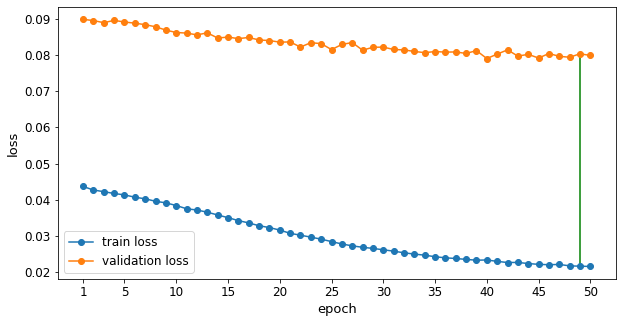

In [ ]:
# PLOT LOSS FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_loss_epoch, val_loss_epoch, epoch, "loss", save_epoch)

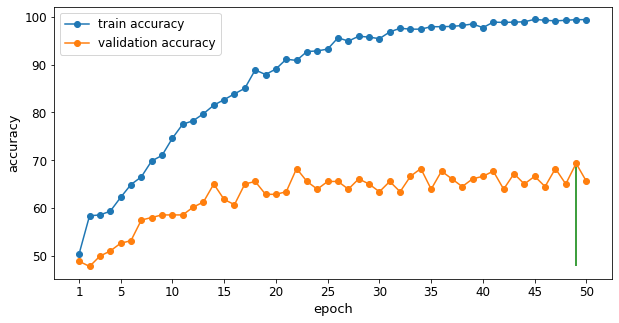

In [ ]:
# PLOT ACCURACY FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_acc_epoch, val_acc_epoch, epoch, "accuracy", save_epoch)

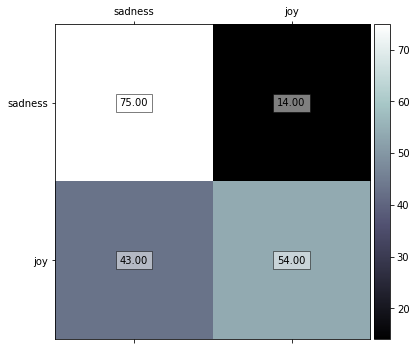

In [ ]:
# PLOT CONFUSION MATRIX
plot_confusion_matrix(y_val[0].to_numpy(), np.array(pred), [0, 1], ["sadness", "joy"])

#### Training - Model 2

num_classes = 2

embed_dim = 300

filter_size = [3x25] + [5x5]

stride = [1x15] + [3x10] + [4x5]

dropout_1 = 0.2

padding = [0x30]

dilation = [1x30]

num_filters = [50x30]

dropout_2 = 0.5

In [ ]:
# INSTANTIATE CNN MODEL
model = CNN(vocab_size=len(word2idx),
            embed_dim=300,
            filter_sizes=[3 for i in range(25)] + [5 for i in range(5)],
            stride=[1 for i in range(15)] + [3 for i in range(10)] + [4 for i in range(5)],
            padding=[0 for i in range(30)],
            dilation=[1 for i in range(30)],
            num_filters=[50 for i in range(30)],
            num_classes=2,
            dropout=0.5)

# SEND MODEL TO "DEVICE" (GPU/CPU) 
model.to(device)

epoch = 50

# INISTANTIATE OPTIMISER
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

print("Total parameters: ", sum([param.nelement() for param in model.parameters()]), "\n")
print(model)

Total parameters:  3062702 

CNN(
  (embedding): Embedding(5194, 300, padding_idx=0, max_norm=5.0)
  (conv1d_list): ModuleList(
    (0): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (2): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (3): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (4): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (5): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (6): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (7): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (8): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (9): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (10): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (11): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (12): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (13): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (14): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (15): Conv1d(300, 50, k

In [ ]:
# TRAINING
train_loss_epoch, train_acc_epoch, \
val_loss_epoch, val_acc_epoch, pred, save_epoch = train(y_train, y_val, \
                                                        train_dataloader, val_dataloader, \
                                                        epoch_num=epoch, \
                                                        loss_fn=nn.CrossEntropyLoss(),
                                                        model_name="joy_sadness/joy_model_2",
                                                        emotion_pair=["sadness", "joy"])

Start training...

  Epoch    |  Train Loss  |   Val Loss   |  Train Accuracy (%)  |   Val Accuracy (%)  
-----------------------------------------------------------------------------------------
         1 |  0.043065286 |  0.089572271 |                55.66 |                49.46
         2 |  0.041602139 |  0.088529550 |                59.05 |                52.15
         3 |  0.040157507 |  0.087727721 |                66.67 |                58.06
         4 |  0.038525227 |  0.086381179 |                77.16 |                64.52
         5 |  0.036689064 |  0.084916967 |                86.12 |                66.67
         6 |  0.034445118 |  0.083549197 |                91.62 |                68.28
         7 |  0.032262718 |  0.082136312 |                94.24 |                68.82
         8 |  0.029859906 |  0.080846042 |                96.80 |                68.28
         9 |  0.027804202 |  0.079780719 |                97.76 |                69.89
        10 |  0.02613

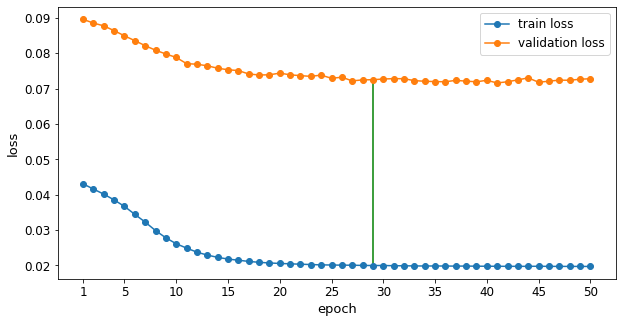

In [ ]:
# PLOT LOSS FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_loss_epoch, val_loss_epoch, epoch, "loss", save_epoch)

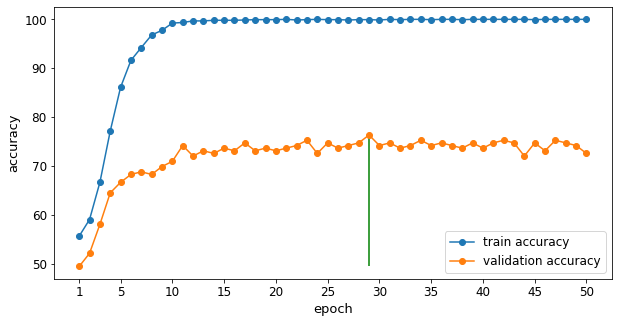

In [ ]:
# PLOT ACCURACY FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_acc_epoch, val_acc_epoch, epoch, "accuracy", save_epoch)

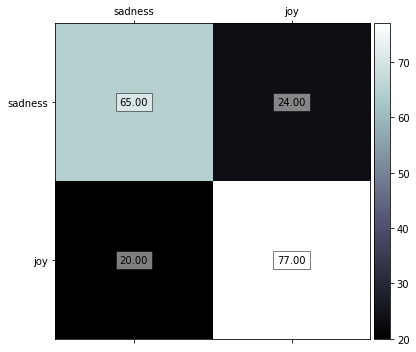

In [ ]:
# PLOT CONFUSION MATRIX
plot_confusion_matrix(y_val[0].to_numpy(), np.array(pred), [0, 1], ["sadness", "joy"])

#### Training - Model 3

num_classes = 2

embed_dim = 300

filter_size = [3x25] + [5x5]

stride = [1x15] + [3x10] + [4x5]

padding = [0x30]

dilation = [1x30]

num_filters = [50x30]

dropout_1 = 0.5

In [ ]:
# INSTANTIATE CNN MODEL
model = CNN_1(vocab_size=len(word2idx),
              embed_dim=300,
              filter_sizes=[3 for i in range(25)] + [5 for i in range(5)],
              stride=[1 for i in range(15)] + [3 for i in range(10)] + [4 for i in range(5)],
              padding=[0 for i in range(30)],
              dilation=[1 for i in range(30)],
              num_filters=[50 for i in range(30)],
              num_classes=2,
              dropout=0.5)

# SEND MODEL TO "DEVICE" (GPU/CPU) 
model.to(device)

epoch = 50

# INISTANTIATE OPTIMISER
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

print("Total parameters: ", sum([param.nelement() for param in model.parameters()]), "\n")
print(model)

Total parameters:  3062702 

CNN_1(
  (embedding): Embedding(5194, 300, padding_idx=0, max_norm=5.0)
  (conv1d_list): ModuleList(
    (0): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (2): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (3): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (4): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (5): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (6): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (7): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (8): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (9): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (10): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (11): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (12): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (13): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (14): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (15): Conv1d(300, 50,

In [ ]:
# TRAINING
train_loss_epoch, train_acc_epoch, \
val_loss_epoch, val_acc_epoch, pred, save_epoch = train(y_train, y_val, \
                                                        train_dataloader, val_dataloader, \
                                                        epoch_num=epoch, \
                                                        loss_fn=nn.CrossEntropyLoss(),
                                                        model_name="joy_sadness/joy_model_3",
                                                        emotion_pair=["sadness", "joy"])

Start training...

  Epoch    |  Train Loss  |   Val Loss   |  Train Accuracy (%)  |   Val Accuracy (%)  
-----------------------------------------------------------------------------------------
         1 |  0.042881850 |  0.089641474 |                56.49 |                49.46
         2 |  0.041276347 |  0.088698499 |                60.84 |                53.76
         3 |  0.039671436 |  0.087545504 |                69.99 |                58.60
         4 |  0.037766564 |  0.086316417 |                81.77 |                64.52
         5 |  0.035579664 |  0.084985172 |                89.00 |                66.67
         6 |  0.033085232 |  0.083628223 |                93.28 |                68.28
         7 |  0.030650413 |  0.082267516 |                95.78 |                69.35
         8 |  0.028304120 |  0.080949465 |                97.63 |                69.89
         9 |  0.026538759 |  0.080004897 |                98.72 |                69.89
        10 |  0.02491

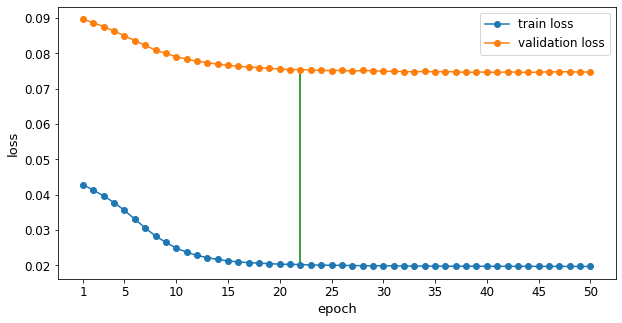

In [ ]:
# PLOT LOSS FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_loss_epoch, val_loss_epoch, epoch, "loss", save_epoch)

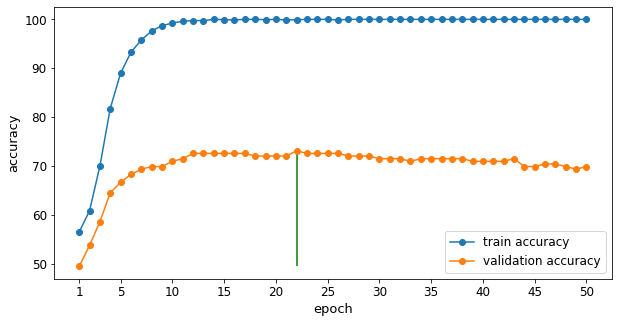

In [ ]:
# PLOT ACCURACY FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_acc_epoch, val_acc_epoch, epoch, "accuracy", save_epoch)

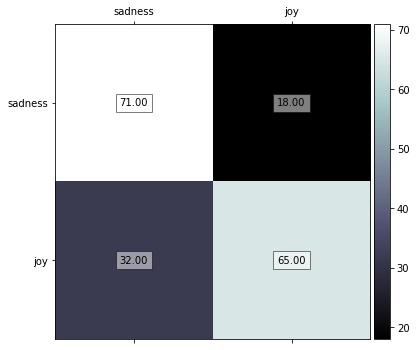

In [ ]:
# PLOT CONFUSION MATRIX
plot_confusion_matrix(y_val[0].to_numpy(), np.array(pred), [0, 1], ["sadness", "joy"])

#### Training - Model 4

num_classes = 2

embed_dim = 300

filter_size = [3x20] + [4x20] + [5x10]

stride = [1x15] + [3x20] + [4x10]

dropout_1 = 0.5

padding = [0x50]

dilation = [1x50]

num_filters = [100x30] + [50x20]

dropout_2 = 0.5

In [ ]:
# INSTANTIATE CNN MODEL
model = CNN(vocab_size=len(word2idx),
            embed_dim=300,
            filter_sizes=[3 for i in range(20)] + [4 for i in range(20)] + [5 for i in range(10)],
            stride=[1 for i in range(20)] + [3 for i in range(20)] + [4 for i in range(10)],
            padding=[0 for i in range(50)],
            dilation=[1 for i in range(50)],
            num_filters=[100 for i in range(30)] + [50 for i in range(20)],
            num_classes=2,
            dropout=0.5)

# SEND MODEL TO "DEVICE" (GPU/CPU) 
model.to(device)

epoch = 50

# INISTANTIATE OPTIMISER
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

print("Total parameters: ", sum([param.nelement() for param in model.parameters()]), "\n")
print(model)

Total parameters:  5920202 

CNN(
  (embedding): Embedding(5194, 300, padding_idx=0, max_norm=5.0)
  (conv1d_list): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (3): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (4): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (5): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (6): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (7): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (8): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (9): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (10): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (11): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (12): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (13): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (14): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (15): Co

In [ ]:
# TRAINING
train_loss_epoch, train_acc_epoch, \
val_loss_epoch, val_acc_epoch, pred, save_epoch = train(y_train, y_val, \
                                                        train_dataloader, val_dataloader, \
                                                        epoch_num=epoch, \
                                                        loss_fn=nn.CrossEntropyLoss(),
                                                        model_name="joy_sadness/joy_model_4",
                                                        emotion_pair=["sadness", "joy"])

Start training...

  Epoch    |  Train Loss  |   Val Loss   |  Train Accuracy (%)  |   Val Accuracy (%)  
-----------------------------------------------------------------------------------------
         1 |  0.042815628 |  0.089023988 |                57.01 |                49.46
         2 |  0.040463927 |  0.087621693 |                66.92 |                57.53
         3 |  0.038192748 |  0.086575710 |                79.97 |                61.29
         4 |  0.035266524 |  0.084962747 |                91.23 |                60.75
         5 |  0.032100976 |  0.083184253 |                95.39 |                64.52
         6 |  0.028938255 |  0.081992711 |                97.57 |                66.13
         7 |  0.026402774 |  0.080799087 |                98.91 |                67.20
         8 |  0.024503795 |  0.080066207 |                99.68 |                65.59
         9 |  0.023101984 |  0.078489682 |                99.68 |                70.97
        10 |  0.02219

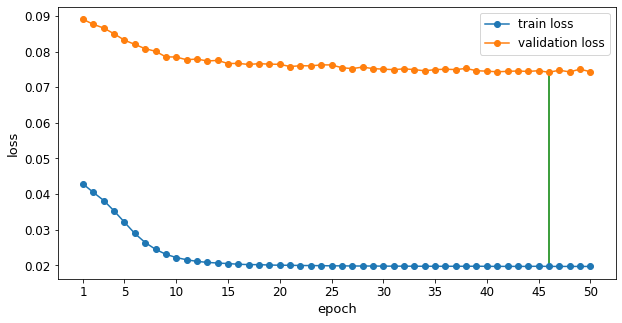

In [ ]:
# PLOT LOSS FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_loss_epoch, val_loss_epoch, epoch, "loss", save_epoch)

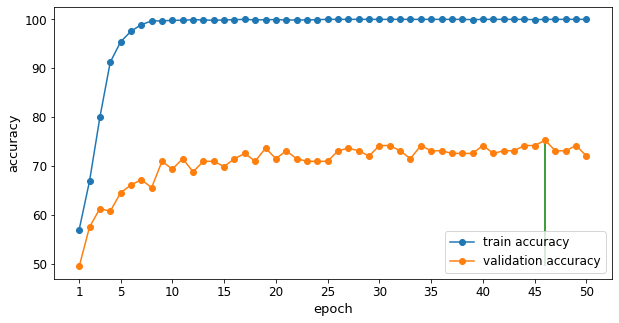

In [ ]:
# PLOT ACCURACY FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_acc_epoch, val_acc_epoch, epoch, "accuracy", save_epoch)

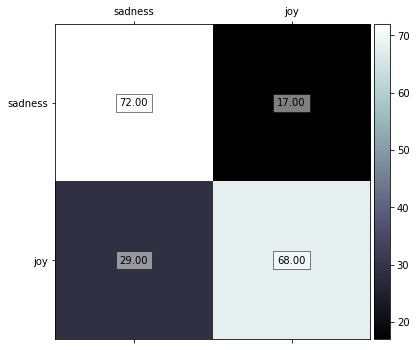

In [ ]:
# PLOT CONFUSION MATRIX
plot_confusion_matrix(y_val[0].to_numpy(), np.array(pred), [0, 1], ["sadness", "joy"])

#### Training - Model 5

num_classes = 2

embed_dim = 300

filter_size = [2x15] + [3x5] + [4x5] + [5x5]

stride = [1x15] + [2x10] + [4x5]

padding = [2x30]

dilation = [1x30]

num_filters = [100x10] + [50x20]

dropout_1 = 0.5

In [ ]:
# INSTANTIATE CNN MODEL
model = CNN_1(vocab_size=len(word2idx),
              embed_dim=300,
              filter_sizes=[2 for i in range(15)] + [3 for i in range(5)] + [4 for i in range(5)] + [5 for i in range(5)],
              stride=[1 for i in range(15)] + [2 for i in range(10)] + [4 for i in range(5)],
              padding=[2 for i in range(30)],
              dilation=[1 for i in range(30)],
              num_filters=[100 for i in range(10)] + [50 for i in range(20)],
              num_classes=2,
              dropout=0.5)

# SEND MODEL TO "DEVICE" (GPU/CPU) 
model.to(device)

epoch = 50

# INISTANTIATE OPTIMISER
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

print("Total parameters: ", sum([param.nelement() for param in model.parameters()]), "\n")
print(model)

Total parameters:  3214202 

CNN_1(
  (embedding): Embedding(5194, 300, padding_idx=0, max_norm=5.0)
  (conv1d_list): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(2,), stride=(1,), padding=(2,))
    (1): Conv1d(300, 100, kernel_size=(2,), stride=(1,), padding=(2,))
    (2): Conv1d(300, 100, kernel_size=(2,), stride=(1,), padding=(2,))
    (3): Conv1d(300, 100, kernel_size=(2,), stride=(1,), padding=(2,))
    (4): Conv1d(300, 100, kernel_size=(2,), stride=(1,), padding=(2,))
    (5): Conv1d(300, 100, kernel_size=(2,), stride=(1,), padding=(2,))
    (6): Conv1d(300, 100, kernel_size=(2,), stride=(1,), padding=(2,))
    (7): Conv1d(300, 100, kernel_size=(2,), stride=(1,), padding=(2,))
    (8): Conv1d(300, 100, kernel_size=(2,), stride=(1,), padding=(2,))
    (9): Conv1d(300, 100, kernel_size=(2,), stride=(1,), padding=(2,))
    (10): Conv1d(300, 50, kernel_size=(2,), stride=(1,), padding=(2,))
    (11): Conv1d(300, 50, kernel_size=(2,), stride=(1,), padding=(2,))
    (12): Conv1d(3

In [ ]:
# TRAINING
train_loss_epoch, train_acc_epoch, \
val_loss_epoch, val_acc_epoch, pred, save_epoch = train(y_train, y_val, \
                                                        train_dataloader, val_dataloader, \
                                                        epoch_num=epoch, \
                                                        loss_fn=nn.CrossEntropyLoss(),
                                                        model_name="joy_sadness/joy_model_5",
                                                        emotion_pair=["sadness", "joy"])

Start training...

  Epoch    |  Train Loss  |   Val Loss   |  Train Accuracy (%)  |   Val Accuracy (%)  
-----------------------------------------------------------------------------------------
         1 |  0.042914769 |  0.089136969 |                55.73 |                50.54
         2 |  0.041303315 |  0.088008806 |                60.59 |                57.53
         3 |  0.039689451 |  0.086708286 |                68.97 |                63.44
         4 |  0.037765792 |  0.085273898 |                80.61 |                66.67
         5 |  0.035425515 |  0.083736103 |                89.70 |                67.74
         6 |  0.033080142 |  0.082253886 |                93.15 |                68.28
         7 |  0.030527398 |  0.080945433 |                95.52 |                66.67
         8 |  0.028228789 |  0.080065445 |                97.44 |                66.67
         9 |  0.026401904 |  0.079096168 |                98.40 |                68.28
        10 |  0.02493

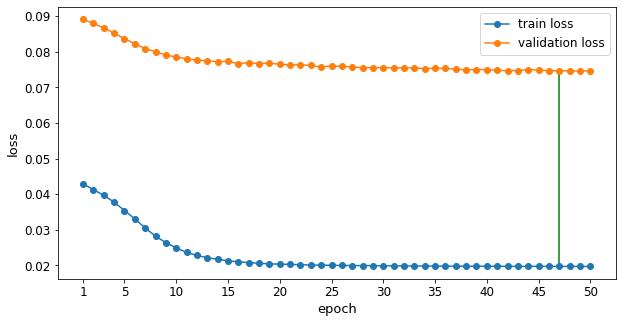

In [ ]:
# PLOT LOSS FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_loss_epoch, val_loss_epoch, epoch, "loss", save_epoch)

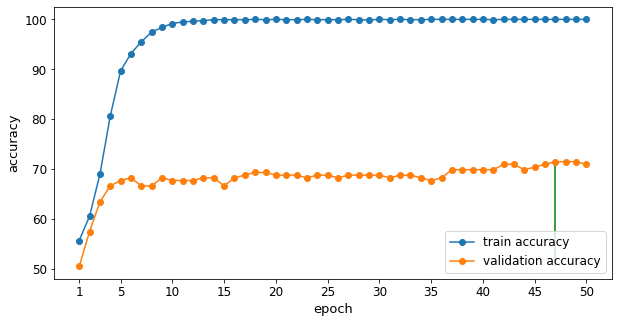

In [ ]:
# PLOT ACCURACY FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_acc_epoch, val_acc_epoch, epoch, "accuracy", save_epoch)

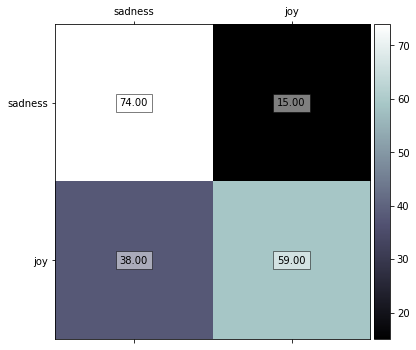

In [ ]:
# PLOT CONFUSION MATRIX
plot_confusion_matrix(y_val[0].to_numpy(), np.array(pred), [0, 1], ["sadness", "joy"])

#### Training - Model 6

num_classes = 2

embed_dim = 300

filter_size = [3x25] + [5x5]

stride = [1x15] + [3x10] + [4x5]

padding = [0x30]

dilation = [1x30]

num_filters = [50x30]

dropout_1 = 0.5

In [ ]:
# INSTANTIATE CNN MODEL
model = CNN_1(vocab_size=len(word2idx),
              embed_dim=300,
              filter_sizes=[3 for i in range(25)] + [5 for i in range(5)],
              stride=[1 for i in range(15)] + [3 for i in range(10)] + [4 for i in range(5)],
              padding=[2 for i in range(25)] + [4 for i in range(5)],
              dilation=[1 for i in range(10)] + [2 for i in range(20)], #+ [2 for i in range(10)],
              num_filters=[50 for i in range(30)],
              num_classes=2,
              dropout=0.5)

# SEND MODEL TO "DEVICE" (GPU/CPU) 
model.to(device)

epoch = 50

# INISTANTIATE OPTIMISER
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

print("Total parameters: ", sum([param.nelement() for param in model.parameters()]), "\n")
print(model)

Total parameters:  3062702 

CNN_1(
  (embedding): Embedding(5194, 300, padding_idx=0, max_norm=5.0)
  (conv1d_list): ModuleList(
    (0): Conv1d(300, 50, kernel_size=(3,), stride=(1,), padding=(2,))
    (1): Conv1d(300, 50, kernel_size=(3,), stride=(1,), padding=(2,))
    (2): Conv1d(300, 50, kernel_size=(3,), stride=(1,), padding=(2,))
    (3): Conv1d(300, 50, kernel_size=(3,), stride=(1,), padding=(2,))
    (4): Conv1d(300, 50, kernel_size=(3,), stride=(1,), padding=(2,))
    (5): Conv1d(300, 50, kernel_size=(3,), stride=(1,), padding=(2,))
    (6): Conv1d(300, 50, kernel_size=(3,), stride=(1,), padding=(2,))
    (7): Conv1d(300, 50, kernel_size=(3,), stride=(1,), padding=(2,))
    (8): Conv1d(300, 50, kernel_size=(3,), stride=(1,), padding=(2,))
    (9): Conv1d(300, 50, kernel_size=(3,), stride=(1,), padding=(2,))
    (10): Conv1d(300, 50, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (11): Conv1d(300, 50, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,)

In [ ]:
# TRAINING
train_loss_epoch, train_acc_epoch, \
val_loss_epoch, val_acc_epoch, pred, save_epoch = train(y_train, y_val, \
                                                        train_dataloader, val_dataloader, \
                                                        epoch_num=epoch, \
                                                        loss_fn=nn.CrossEntropyLoss(),
                                                        model_name="joy_sadness/joy_model_6",
                                                        emotion_pair=["sadness", "joy"])

Start training...

  Epoch    |  Train Loss  |   Val Loss   |  Train Accuracy (%)  |   Val Accuracy (%)  
-----------------------------------------------------------------------------------------
         1 |  0.042939895 |  0.089506401 |                55.53 |                48.92
         2 |  0.041395789 |  0.088447008 |                59.56 |                54.84
         3 |  0.039873973 |  0.087227577 |                68.39 |                59.14
         4 |  0.038159847 |  0.085885136 |                78.89 |                63.98
         5 |  0.035868236 |  0.084298559 |                87.91 |                65.05
         6 |  0.033331583 |  0.082711916 |                93.35 |                68.28
         7 |  0.031004233 |  0.081271710 |                95.20 |                69.89
         8 |  0.028724484 |  0.079867634 |                97.06 |                70.97
         9 |  0.026806203 |  0.078875330 |                98.14 |                70.43
        10 |  0.02525

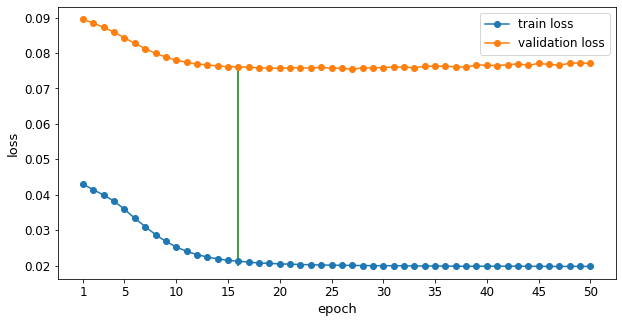

In [ ]:
## PLOT LOSS FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_loss_epoch, val_loss_epoch, epoch, "loss", save_epoch)

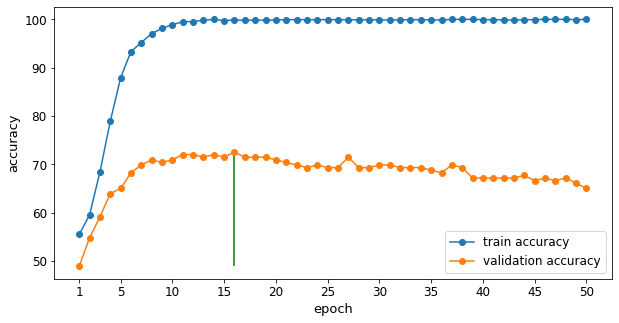

In [ ]:
# PLOT ACCURACY FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_acc_epoch, val_acc_epoch, epoch, "accuracy", save_epoch)

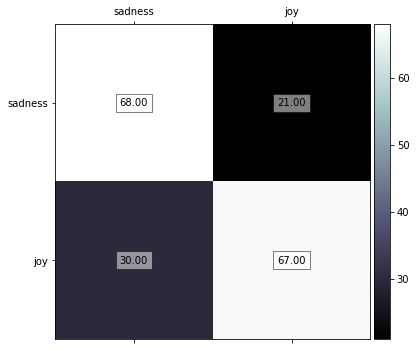

In [ ]:
# PLOT CONFUSION MATRIX
plot_confusion_matrix(y_val[0].to_numpy(), np.array(pred), [0, 1], ["sadness", "joy"])

#### Training - Model 7

num_classes = 2

embed_dim = 300

filter_size = [3x25] + [5x5]

stride = [1x15] + [3x10] + [4x5]

padding = [0x30]

dilation = [1x30]

num_filters = [50x30]

dropout_1 = 0.5

max pool --> avg pool

In [ ]:
# INSTANTIATE CNN MODEL
model = CNN_2(vocab_size=len(word2idx),
              embed_dim=300,
              filter_sizes=[3 for i in range(25)] + [5 for i in range(5)],
              stride=[1 for i in range(15)] + [3 for i in range(10)] + [4 for i in range(5)],
              padding=[0 for i in range(30)],
              dilation=[1 for i in range(30)],
              num_filters=[50 for i in range(30)],
              num_classes=2,
              dropout=0.5)

# SEND MODEL TO "DEVICE" (GPU/CPU) 
model.to(device)

epoch = 50

# INISTANTIATE OPTIMISER
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

print("Total parameters: ", sum([param.nelement() for param in model.parameters()]), "\n")
print(model)

Total parameters:  3062702 

CNN_2(
  (embedding): Embedding(5194, 300, padding_idx=0, max_norm=5.0)
  (conv1d_list): ModuleList(
    (0): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (2): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (3): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (4): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (5): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (6): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (7): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (8): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (9): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (10): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (11): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (12): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (13): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (14): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (15): Conv1d(300, 50,

In [ ]:
# TRAINING
train_loss_epoch, train_acc_epoch, \
val_loss_epoch, val_acc_epoch, pred, save_epoch = train(y_train, y_val, \
                                                        train_dataloader, val_dataloader, \
                                                        epoch_num=epoch, \
                                                        loss_fn=nn.CrossEntropyLoss(),
                                                        model_name="joy_sadness/joy_model_7",
                                                        emotion_pair=["sadness", "joy"])

Start training...

  Epoch    |  Train Loss  |   Val Loss   |  Train Accuracy (%)  |   Val Accuracy (%)  
-----------------------------------------------------------------------------------------
         1 |  0.043294312 |  0.089580737 |                54.77 |                47.85
         2 |  0.042838406 |  0.089641949 |                56.43 |                47.85
         3 |  0.042332004 |  0.089508396 |                56.43 |                47.85
         4 |  0.041609930 |  0.088959867 |                57.33 |                49.46
         5 |  0.040457638 |  0.087759106 |                62.06 |                57.53
         6 |  0.038752219 |  0.085940637 |                73.13 |                63.44
         7 |  0.036471811 |  0.083932611 |                82.79 |                65.59
         8 |  0.033853388 |  0.082131510 |                87.84 |                67.74
         9 |  0.031324588 |  0.080730756 |                90.47 |                67.74
        10 |  0.02917

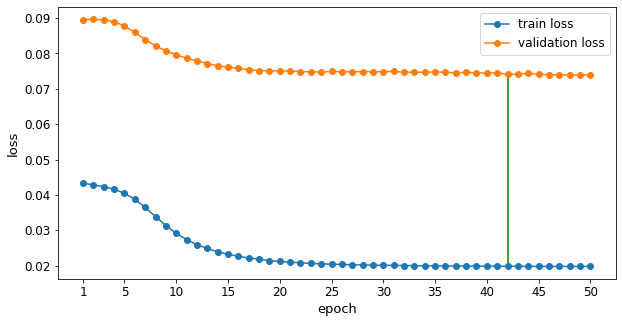

In [ ]:
# PLOT LOSS FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_loss_epoch, val_loss_epoch, epoch, "loss", save_epoch)

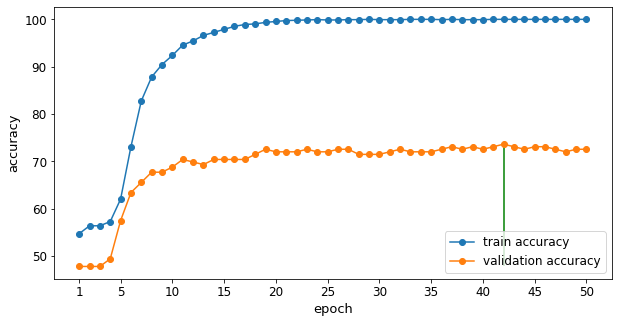

In [ ]:
# PLOT ACCURACY FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_acc_epoch, val_acc_epoch, epoch, "accuracy", save_epoch)

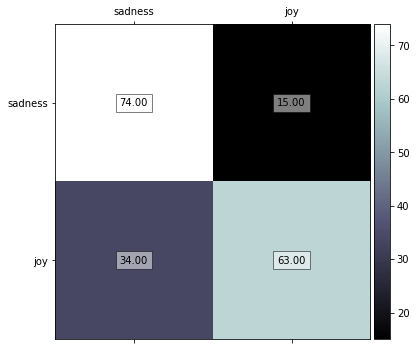

In [ ]:
# PLOT CONFUSION MATRIX
plot_confusion_matrix(y_val[0].to_numpy(), np.array(pred), [0, 1], ["sadness", "joy"])

#### Training - Model 8

num_classes = 2

embed_dim = 300

filter_size = [3x25] + [5x5]

stride = [1x15] + [3x10] + [4x5]

padding = [0x30]

dilation = [1x30]

num_filters = [50x30]

dropout_1 = 0.5

batch size: 16 --> 128

In [ ]:
# INSTANTIATE CNN MODEL
model = CNN_1(vocab_size=len(word2idx),
              embed_dim=300,
              filter_sizes=[3 for i in range(25)] + [5 for i in range(5)],
              stride=[1 for i in range(15)] + [3 for i in range(10)] + [4 for i in range(5)],
              padding=[0 for i in range(30)],
              dilation=[1 for i in range(30)],
              num_filters=[50 for i in range(30)],
              num_classes=2,
              dropout=0.5)

# SEND MODEL TO "DEVICE" (GPU/CPU) 
model.to(device)

epoch = 50

# INISTANTIATE OPTIMISER
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

print("Total parameters: ", sum([param.nelement() for param in model.parameters()]), "\n")
print(model)

Total parameters:  3062702 

CNN_1(
  (embedding): Embedding(5194, 300, padding_idx=0, max_norm=5.0)
  (conv1d_list): ModuleList(
    (0): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (2): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (3): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (4): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (5): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (6): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (7): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (8): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (9): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (10): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (11): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (12): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (13): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (14): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (15): Conv1d(300, 50,

In [ ]:
# TRAINING
train_loss_epoch, train_acc_epoch, \
val_loss_epoch, val_acc_epoch, pred, save_epoch = train(y_train, y_val, \
                                                        train_dataloader, val_dataloader, \
                                                        epoch_num=epoch, \
                                                        loss_fn=nn.CrossEntropyLoss(),
                                                        model_name="joy_sadness/joy_model_8",
                                                        emotion_pair=["sadness", "joy"])

Start training...

  Epoch    |  Train Loss  |   Val Loss   |  Train Accuracy (%)  |   Val Accuracy (%)  
-----------------------------------------------------------------------------------------
         1 |  0.003083831 |  0.089571150 |                54.25 |                47.31
         2 |  0.003032773 |  0.089905776 |                57.13 |                47.85
         3 |  0.002994691 |  0.090164114 |                56.56 |                47.85
         4 |  0.002965793 |  0.090244539 |                56.69 |                47.85
         5 |  0.002940287 |  0.090162144 |                56.69 |                47.85
         6 |  0.002915433 |  0.089969791 |                56.88 |                47.85
         7 |  0.002883731 |  0.089740370 |                57.45 |                47.85
         8 |  0.002848746 |  0.089495019 |                58.99 |                48.92
         9 |  0.002824812 |  0.089263920 |                60.52 |                49.46
        10 |  0.00279

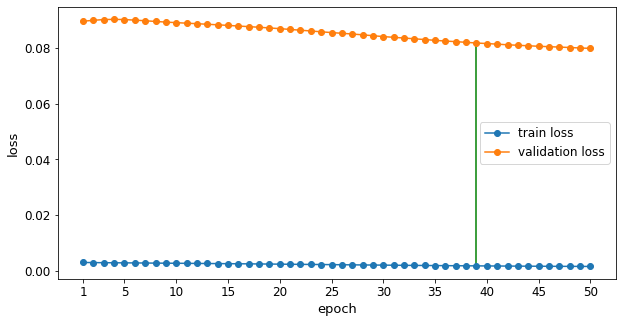

In [ ]:
# PLOT LOSS FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_loss_epoch, val_loss_epoch, epoch, "loss", save_epoch)

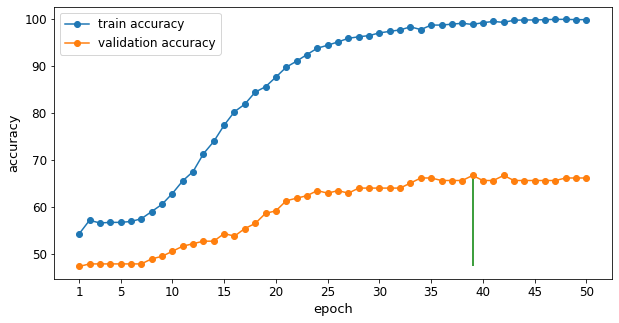

In [ ]:
# PLOT ACCURACY FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_acc_epoch, val_acc_epoch, epoch, "accuracy", save_epoch)

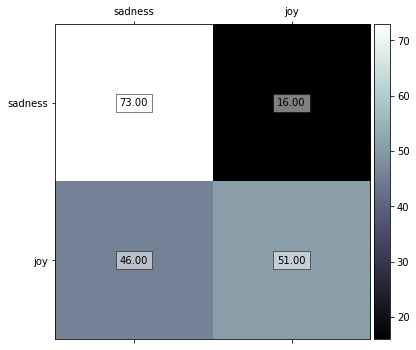

In [ ]:
# PLOT CONFUSION MATRIX
plot_confusion_matrix(y_val[0].to_numpy(), np.array(pred), [0, 1], ["sadness", "joy"])

### Testing

In [ ]:
model = torch.load(model_path + "joy_sadness/joy_model_2.pt")
model.eval()

CNN(
  (embedding): Embedding(5194, 300, padding_idx=0, max_norm=5.0)
  (conv1d_list): ModuleList(
    (0): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (2): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (3): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (4): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (5): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (6): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (7): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (8): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (9): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (10): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (11): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (12): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (13): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (14): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (15): Conv1d(300, 50, kernel_size=(3,), stride=(3,))

In [ ]:
preds_test = []
loss_fn = nn.CrossEntropyLoss()
total_loss_test = 0

for b_input_idx, b_labels in test_dataloader:
            
    # LOAD BATCH TO DEVICE
    b_input_idx = b_input_idx.to(device)
    b_labels = b_labels.to(device)

    # PERFORM A FORWARD PASS
    with torch.no_grad():
        logits = model(b_input_idx).type(torch.float)

    # GET ACCURACY
    preds_test.extend(logits.argmax(axis=1).numpy())

# ACCURACY
y_test_tensor = torch.tensor(y_test[0].values)
pred_test = torch.FloatTensor(np.array(preds_test))
acc_test = torch.eq(pred_test, y_test_tensor).type(torch.float).sum().item()/len(y_test[0].values)*100
print("Test accuracy: ", acc_test)

Test accuracy:  76.8918918918919


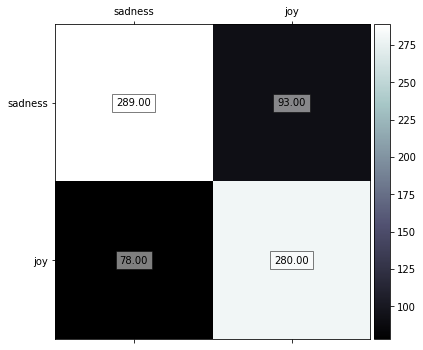

In [ ]:
# PLOT CONFUSION MATRIX
plot_confusion_matrix(y_test[0].to_numpy(), np.array(pred_test), [0, 1], ["sadness", "joy"])

In [ ]:
f1 = BinaryF1Score()
print("f1-macro: ", f1(pred_test, y_test_tensor).item())

f1-macro:  0.7660738825798035


## Training Task - Anger & Sadness

### Loading Dataset (Regular) - Anger & Sadness

In [ ]:
# LOADING DATA
data_path_joy_sadness = "/content/drive/My Drive/ML4NLP_assignment/exercise_3/data/my_data/anger_sadness/"
X_train, y_train, X_val, y_val, X_test, y_test = load_data(data_path_joy_sadness)
print("train size: {}\nvalidation size: {}\ntest size: {}\n".format(len(X_train[0]), 
                                                                    len(X_val[0]), 
                                                                    len(X_test[0])))

train size: 2255
validation size: 249
test size: 940



### Data Preprocessing

In [ ]:
# DATA PREPROCESSING
data_preprocessing = DataPreprocessing()
X_train[0] = data_preprocessing.clean(X_train[0])
X_val[0] = data_preprocessing.clean(X_val[0])
X_test[0] = data_preprocessing.clean(X_test[0])

In [ ]:
# LABEL PREPROCESSING
y_train = y_train.replace(3, 1)
y_val = y_val.replace(3, 1)
y_test = y_test.replace(3, 1)

### Tokenising

In [ ]:
# TRAINING DATA TOKENISING
tokenised_texts, word2idx, max_len = tokenise(X_train[0])
# VALIDATION DATA TOKENISING
tokenised_texts_val, _, max_len_val = tokenise(X_val[0])
# TESTING DATA TOKENISING
tokenised_texts_test, _, max_len_test = tokenise(X_test[0])

### Encoding

In [ ]:
# GET LARGEST MAX_LEN
max_len = max([max_len, max_len_val, max_len_test])
print("Each sentence is padded to the size: ", max_len)
# TRAINING DATA ENCODING
X_train_input, y_train_label = encode(tokenised_texts, word2idx, max_len, y_train)
# VALIDATION DATA ENCODING
X_val_input, y_val_label = encode(tokenised_texts_val, word2idx, max_len, y_val)
# TESTING DATA ENCODING
X_test_input, y_test_label = encode(tokenised_texts_test, word2idx, max_len, y_test)

Each sentence is padded to the size:  32


### Preparing Data for Training & Testing

In [ ]:
# TRAINING DATA
train_dataloader = data_preparation(X_train_input, y_train_label, 16)
# VALIDATION DATA
val_dataloader = data_preparation(X_val_input, y_val_label, 8)
# TESTING DATA
test_dataloader = data_preparation(X_test_input, y_test_label, 16)

### Training

In [ ]:
# INSTANTIATE CNN MODEL
model = CNN(vocab_size=len(word2idx),
            embed_dim=300,
            filter_sizes=[3 for i in range(25)] + [5 for i in range(5)],
            stride=[1 for i in range(15)] + [3 for i in range(10)] + [4 for i in range(5)],
            padding=[0 for i in range(30)],
            dilation=[1 for i in range(30)],
            num_filters=[50 for i in range(30)],
            num_classes=2,
            dropout=0.5)

# SEND MODEL TO "DEVICE" (GPU/CPU) 
model.to(device)

epoch = 50

# INISTANTIATE OPTIMISER
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

print("Total parameters: ", sum([param.nelement() for param in model.parameters()]), "\n")
print(model)

Total parameters:  3473102 

CNN(
  (embedding): Embedding(6562, 300, padding_idx=0, max_norm=5.0)
  (conv1d_list): ModuleList(
    (0): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (2): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (3): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (4): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (5): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (6): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (7): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (8): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (9): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (10): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (11): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (12): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (13): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (14): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (15): Conv1d(300, 50, k

In [ ]:
# TRAINING
train_loss_epoch, train_acc_epoch, \
val_loss_epoch, val_acc_epoch, pred, save_epoch = train(y_train, y_val, \
                                                        train_dataloader, val_dataloader, \
                                                        epoch_num=epoch, \
                                                        loss_fn=nn.CrossEntropyLoss(),
                                                        model_name="anger_sadness/anger_model",
                                                        emotion_pair=["anger", "joy"])

Start training...

  Epoch    |  Train Loss  |   Val Loss   |  Train Accuracy (%)  |   Val Accuracy (%)  
-----------------------------------------------------------------------------------------
         1 |  0.041360130 |  0.082330715 |                62.04 |                64.26
         2 |  0.040132993 |  0.081438313 |                62.31 |                64.26
         3 |  0.038863409 |  0.080692755 |                64.30 |                65.06
         4 |  0.036970871 |  0.079156874 |                72.37 |                67.47
         5 |  0.034556001 |  0.077439962 |                82.13 |                72.69
         6 |  0.031846470 |  0.074992102 |                88.47 |                77.91
         7 |  0.029409630 |  0.073096066 |                92.28 |                78.31
         8 |  0.027243049 |  0.071727555 |                95.12 |                76.71
         9 |  0.025480812 |  0.070227264 |                96.90 |                76.31
        10 |  0.02426

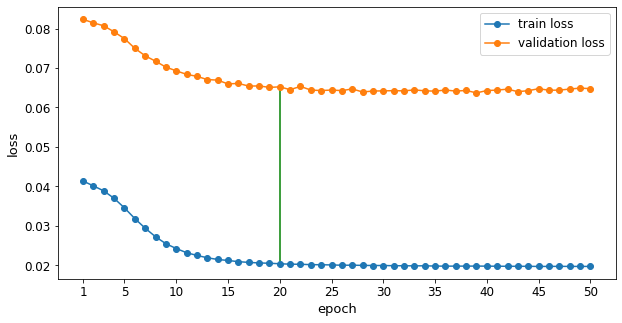

In [ ]:
# PLOT LOSS FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_loss_epoch, val_loss_epoch, epoch, "loss", save_epoch)

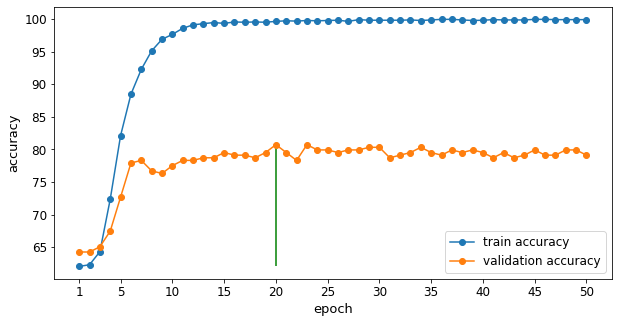

In [ ]:
# PLOT ACCURACY FOR EACH EPOCH THROUGHOUT THE TRAINING PROCESS
plot(train_acc_epoch, val_acc_epoch, epoch, "accuracy", save_epoch)

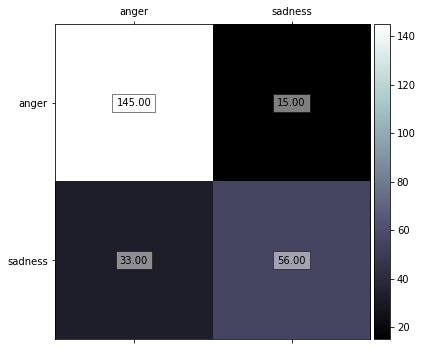

In [ ]:
# PLOT CONFUSION MATRIX
plot_confusion_matrix(y_val[0].to_numpy(), np.array(pred), [0, 1], ["anger", "sadness"])

### Testing

In [ ]:
model = torch.load(model_path + "anger_sadness/anger_model.pt")
model.eval()

CNN(
  (embedding): Embedding(6562, 300, padding_idx=0, max_norm=5.0)
  (conv1d_list): ModuleList(
    (0): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (2): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (3): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (4): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (5): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (6): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (7): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (8): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (9): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (10): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (11): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (12): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (13): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (14): Conv1d(300, 50, kernel_size=(3,), stride=(1,))
    (15): Conv1d(300, 50, kernel_size=(3,), stride=(3,))

In [ ]:
preds_test = []
loss_fn = nn.CrossEntropyLoss()
total_loss_test = 0

for b_input_idx, b_labels in test_dataloader:
            
    # LOAD BATCH TO DEVICE
    b_input_idx = b_input_idx.to(device)
    b_labels = b_labels.to(device)

    # PERFORM A FORWARD PASS
    with torch.no_grad():
        logits = model(b_input_idx).type(torch.float)

    # GET ACCURACY
    preds_test.extend(logits.argmax(axis=1).numpy())

# ACCURACY
y_test_tensor = torch.tensor(y_test[0].values)
pred_test = torch.FloatTensor(np.array(preds_test))
acc_test = torch.eq(pred_test, y_test_tensor).type(torch.float).sum().item()/len(y_test[0].values)*100
print("Test accuracy: ", acc_test)

Test accuracy:  78.93617021276596


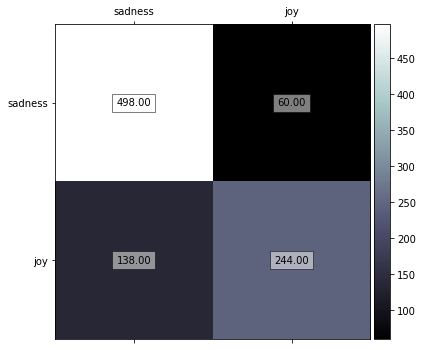

In [ ]:
# PLOT CONFUSION MATRIX
plot_confusion_matrix(y_test[0].to_numpy(), np.array(pred_test), [0, 1], ["sadness", "joy"])

In [ ]:
f1 = BinaryF1Score()
print("f1-macro: ", f1(pred_test, y_test_tensor).item())

f1-macro:  0.7113702893257141
